In [1]:
print("numpy version " + np.__version__)
print("pandas version " + pd.__version__)
print("tensorflow version " + tf.__version__)
print("keras version " + keras.__version__)
print("scipy version " + scipy.__version__)
print("sklearn version " + sklearn.__version__)

NameError: name 'np' is not defined

In [5]:
!nvidia-smi

Tue Sep 28 23:02:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.41       Driver Version: 471.41       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:2B:00.0  On |                  N/A |
|  0%   55C    P0    55W / 220W |    624MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import tensorflow as tf

print(tf.__version__)  # 출력 결과: 2.6.0
print(tf.version.VERSION)  # 2.6.0
print(tf.version.GIT_VERSION)  # v2.6.0-rc2-32-g919f693420e
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))  # Num GPUs Available:  1
print(tf.config.list_physical_devices('GPU'))


2.6.0
2.6.0
v2.6.0-rc2-32-g919f693420e
Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import tensorflow as tf

print(tf.__version__)  # 출력 결과: 2.6.0
print(tf.config.list_physical_devices('GPU'))  # 출력 결과: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load Data

In [3]:
import pandas as pd
import numpy as np
pd.set_option("display.max_column", 600)
pd.set_option("display.max_row", 600)

import warnings
warnings.filterwarnings("ignore")

path = "C:/DRworks/"

train = pd.read_csv(path + "/train_features.csv")
train_acc, train_gy  = train.iloc[:, 2:5], train.iloc[:, 5:]
train_time = train.time[:600]/50

train_label = pd.read_csv(path + "/train_labels.csv")
train_y = train_label.label

test = pd.read_csv(path + "/test_features.csv")
submission = pd.read_csv(path + "/sample_submission.csv")

### Data Aug

DACON.Dobby님께서 공유해주신 time rolling을 이용했습니다.  
논문에서 다양한 augmentation 방법을 찾을 수 있었는데 그 중에서 rotation과 permutation 기법을 이용했습니다.  
rotation은 wearable센서의 무작위한 착용 방향을 고려한 데이터 증강 방법입니다.  
permutation은 신호를 n segment로 나누어 순서를 랜덤하게 바꿔주는 방법입니다.

In [4]:

import scipy
from transforms3d.axangles import axangle2mat

def rolling(data):
    for j in np.random.choice(data.shape[0], int(data.shape[0]*2/3)):
        data[j] = np.roll(data[j], np.random.choice(data.shape[1]), axis= 0)
    return data

def rotation(data):
    axis = np.random.uniform(low=-1, high=1, size=data.shape[1])
    angle = np.random.uniform(low=-np.pi, high=np.pi)
    return np.matmul(data , axangle2mat(axis,angle))

def permutation(data, nPerm=4, mSL=10):
    data_new = np.zeros(data.shape)
    idx = np.random.permutation(nPerm)
    bWhile = True
    while bWhile == True:
        segs = np.zeros(nPerm+1, dtype=int)
        segs[1:-1] = np.sort(np.random.randint(mSL, data.shape[0]-mSL, nPerm-1))
        segs[-1] = data.shape[0]
        if np.min(segs[1:]-segs[0:-1]) > mSL:
            bWhile = False
    pp = 0
    for ii in range(nPerm):
        data_temp = data[segs[idx[ii]]:segs[idx[ii]+1],:]
        data_new[pp:pp+len(data_temp),:] = data_temp
        pp += len(data_temp)
    return(data_new)


def combine_aug(data, k, aug_P = 0):
    data_ = data.copy()
    if aug_P == 0:
        if (k+1) % 2 == 0:
            for i in np.random.choice(int(data.shape[0]/600), int(data.shape[0]/600*2/3)):
                data_[600*i:600*(i+1)] = rotation(np.array(data_[600*i:600*(i+1)]))
        if (k+1) % 2 == 1:
            for i in np.random.choice(int(data.shape[0]/600), int(data.shape[0]/600*2/3)):
                data_[600*i:600*(i+1)] = permutation(np.array(data_[600*i:600*(i+1)]))
                
    if aug_P != 0:
        pass
    return data_

### rotation, permutation에 관한 참고  

T. T. Um et al., “Data augmentation of wearable sensor data for parkinson’s disease monitoring using convolutional neural networks,” in Proceedings of the 19th ACM International Conference on Multimodal Interaction, ser. ICMI 2017. New York, NY, USA: ACM, 2017, pp. 216–220.

https://dl.acm.org/citation.cfm?id=3136817

https://arxiv.org/abs/1706.00527

@inproceedings{TerryUm_ICMI2017, author = {Um, Terry T. and Pfister, Franz M. J. and Pichler, Daniel and Endo, Satoshi and Lang, Muriel and Hirche, Sandra and Fietzek, Urban and Kuli\'{c}, Dana}, title = {Data Augmentation of Wearable Sensor Data for Parkinson's Disease Monitoring Using Convolutional Neural Networks}, booktitle = {Proceedings of the 19th ACM International Conference on Multimodal Interaction}, series = {ICMI 2017}, year = {2017}, isbn = {978-1-4503-5543-8}, location = {Glasgow, UK}, pages = {216--220}, numpages = {5}, doi = {10.1145/3136755.3136817}, acmid = {3136817}, publisher = {ACM}, address = {New York, NY, USA}, keywords = {Parkinson\&#39;s disease, convolutional neural networks, data augmentation, health monitoring, motor state detection, wearable sensor}, }

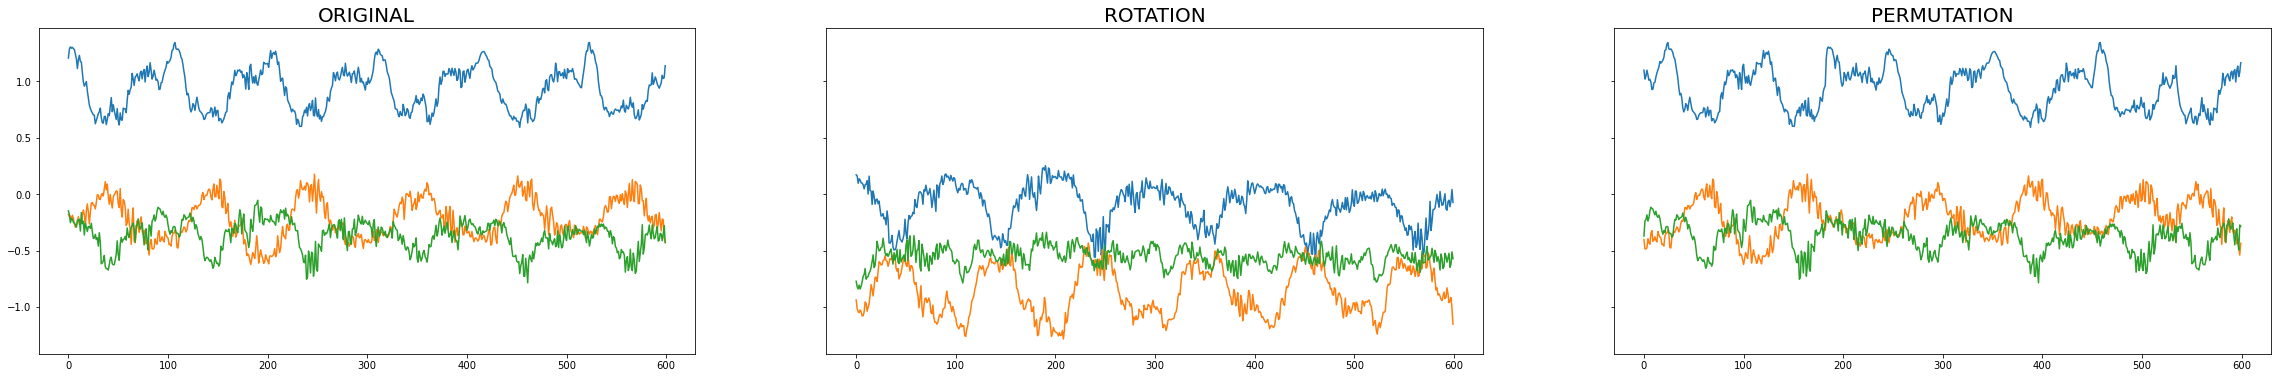

In [5]:
import matplotlib.pyplot as plt

np.random.seed(10)

f, axes = plt.subplots(1, 3, sharex=True, sharey=True)

f.set_size_inches((40, 6))
f.patch.set_facecolor("white")

axes[0].plot(train_acc[:600])
axes[0].set_title("ORIGINAL", fontsize = 20)
axes[1].plot(rotation(train_acc[:600]))
axes[1].set_title("ROTATION", fontsize = 20)
axes[2].plot(permutation(np.array(train_acc[:600])))
axes[2].set_title("PERMUTATION", fontsize = 20)
plt.show()

최종적으로 사용한 데이터 증강 method  
- 짝수 epoch에 rolling, permutation 결합  
- 홀수 epoch에 rolling, rotation 결합

LB public score 기준  
  
- rolling만 사용했을경우 0.51  
- rolling + rotation combine한 경우 0.41  
- 최종적인 aug 방법을 사용한 경우 0.386

### Feature

In [6]:
from math import atan, sqrt
from scipy.integrate import cumtrapz

def get_mag(data):
    return (data.iloc[:, 0]**2) + (data.iloc[:, 1]**2) + (data.iloc[:, 2]**2)

def get_mul(data):
    return data.iloc[:, 0] * data.iloc[:, 1] * data.iloc[:, 2]


##########################################################################################################################

def get_roll_pitch(data):
    roll = (data.iloc[:,1]/(data.iloc[:,0]**2 + data.iloc[:,2]**2).apply(lambda x : sqrt(x))).apply(lambda x : atan(x))*180/np.pi
    pitch = (data.iloc[:,0]/(data.iloc[:,1]**2 + data.iloc[:,2]**2).apply(lambda x : sqrt(x))).apply(lambda x : atan(x))*180/np.pi
    return pd.concat([roll, pitch], axis= 1)

##########################################################################################################################

def setting(data, data_, case = 0):
    if case == 0:
        for i in range(0, data.shape[0], 600):
            data[i] = data_[i] - data_[i+599]
    else:
        for i in range(0, data.shape[0], 600):
            data[i: i+5] = data_[i: i+5].values - data_[i+594:i+599].values
    return data
        
def get_diff(data, case = 0):
    if case == 0:
        x_dif, y_dif, z_dif = data.iloc[:, 0].diff(), data.iloc[:, 1].diff(), data.iloc[:, 2].diff()
    else:
        x_dif, y_dif, z_dif = data.iloc[:, 0].diff(5), data.iloc[:, 1].diff(5), data.iloc[:, 2].diff(5)
    return pd.concat([setting(x_dif, data.iloc[:, 0], case),
                      setting(y_dif, data.iloc[:, 1], case),
                      setting(z_dif, data.iloc[:, 2], case)], axis= 1)
############################################################################################################################

def get_cumtrapz(acc):
    acc_x, acc_y, acc_z = [], [], []
    ds_x, ds_y, ds_z = [], [], []
    for i in range(int(acc.shape[0]/600)):
        acc_x.append(pd.DataFrame(cumtrapz(acc.iloc[600*i:600*(i+1), 0], train_time, initial=0)))
        acc_y.append(pd.DataFrame(cumtrapz(acc.iloc[600*i:600*(i+1), 1], train_time, initial=0)))
        acc_z.append(pd.DataFrame(cumtrapz(acc.iloc[600*i:600*(i+1), 2], train_time, initial=0)))
        ds_x.append(pd.DataFrame(cumtrapz(cumtrapz(acc.iloc[600*i:600*(i+1), 0], train_time, initial=0), train_time, initial=0)))
        ds_y.append(pd.DataFrame(cumtrapz(cumtrapz(acc.iloc[600*i:600*(i+1), 1], train_time, initial=0), train_time, initial=0)))
        ds_z.append(pd.DataFrame(cumtrapz(cumtrapz(acc.iloc[600*i:600*(i+1), 2], train_time, initial=0), train_time, initial=0)))
    return (pd.concat([pd.concat(acc_x), pd.concat(acc_y), pd.concat(acc_z)], axis = 1).reset_index(drop=True),
           pd.concat([pd.concat(ds_x), pd.concat(ds_y), pd.concat(ds_z)], axis= 1).reset_index(drop = True))

 가속도계와 자이로스코프에서 얻을 수 있는 간단한 변수들만을 추가하였습니다.

### Make Dataset

In [7]:
def train_dataset(acc_data, gy_data, i, aug_P = 0):

    aug_acc = combine_aug(acc_data, i, aug_P)
    aug_gy = combine_aug(gy_data, i, aug_P)
    
    diff_acc = get_diff(aug_acc)
    #diff_acc_5 = get_diff(aug_acc, 1)
    
    roll_pitch_acc = get_roll_pitch(aug_acc)
    mag_acc, mul_acc = get_mag(aug_acc), get_mul(aug_acc)
    mag_mul_acc = pd.concat([mag_acc, mul_acc], axis= 1)
    #accvel, disp = get_cumtrapz(aug_acc)

    diff_gy = get_diff(aug_gy)
    #diff_gy_5 = get_diff(aug_gy, 1)
    mag_gy, mul_gy = get_mag(aug_gy), get_mul(aug_gy)
    mag_mul_gy = pd.concat([mag_gy, mul_gy], axis= 1)

    return pd.concat([aug_acc, diff_acc, roll_pitch_acc, mag_mul_acc,
                     aug_gy, diff_gy, mag_mul_gy], axis= 1)

def test_dataset(acc_data, gy_data):
    
    diff_acc = get_diff(acc_data)
    #diff_acc_5 = get_diff(acc_data, 1)
    
    roll_pitch_acc = get_roll_pitch(acc_data)
    mag_acc, mul_acc = get_mag(acc_data), get_mul(acc_data)
    mag_mul_acc = pd.concat([mag_acc, mul_acc], axis= 1)
    #accvel, disp = get_cumtrapz(acc_data)

    diff_gy = get_diff(gy_data)
    #diff_gy_5 = get_diff(gy_data, 1)
    mag_gy, mul_gy = get_mag(gy_data), get_mul(gy_data)
    mag_mul_gy = pd.concat([mag_gy, mul_gy], axis= 1)

    return pd.concat([acc_data, diff_acc, roll_pitch_acc, mag_mul_acc,
                      gy_data, diff_gy, mag_mul_gy], axis= 1)

### Scaler

train data만 사용하여 scaler를 만들었습니다.

In [8]:
import sklearn
from sklearn.preprocessing import StandardScaler

data_for_scaler = test_dataset(train_acc, train_gy) # train data만 사용
scaler = StandardScaler().fit(np.array(data_for_scaler))

data_for_scaler = np.array(data_for_scaler).reshape(-1, 600, data_for_scaler.shape[1])
########################################################################################
test_x = test_dataset(test.iloc[:, 2:5], test.iloc[:, 5:])

test_X = scaler.transform(np.array(test_x)).reshape(-1, 600, test_x.shape[1])

### Model

이번 대회를 진행하면서 다양한 모델을 시도해 보았습니다. 그 중에 DACON.Dobby님께서 공유해주신 코드를 보고 self attention을 gru와 dense layer사이에 넣어보기도  
하였으나 과적합이 일어나 최종적으로는 gru layer + pooling layer + dense layer를 조합하여 선택했습니다. 개인적인 견해이지만 적은 데이터에는 gru를 사용하는 것이 accuracy와  loss사이의 trade off를 잘 조절해주는 것 같습니다.

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

최적의 모델을 찾기 위해 파라미터를 수정해 가면서 모니터링한 결과 각각의 모델의 성능은 비슷하나 설명할 수 있는 부분이 살짝 다르다고 판단하여  
각 모델당 2번씩 seed를 다르게 부여하여, 총 8개 결과의 평균을 냈습니다.

In [10]:
def First_model():
    inputs = L.Input(shape = (data_for_scaler.shape[1], data_for_scaler.shape[2]))
    gru1 = L.GRU(256, return_sequences = True, dropout = 0.2)(inputs)
    ap = L.AveragePooling1D()(gru1)
    gru2 = L.GRU(150, return_sequences = True)(ap)
    GAP = L.GlobalAveragePooling1D()(gru2)
    dense = L.Dense(61, activation = "softmax")(GAP)
    return keras.models.Model(inputs, dense)

def Second_model():
    inputs = L.Input(shape = (data_for_scaler.shape[1], data_for_scaler.shape[2]))
    gru1 = L.GRU(256, return_sequences = True, dropout = 0.2)(inputs)
    mp = L.MaxPool1D()(gru1)
    ap = L.AveragePooling1D()(gru1)
    concat1 = L.Concatenate()([mp, ap])
    gru2 = L.GRU(150, return_sequences = True, dropout = 0.2)(concat1)
    GAP = L.GlobalAveragePooling1D()(gru2)
    dense = L.Dense(61, activation = "softmax")(GAP)
    return keras.models.Model(inputs, dense)

def Third_model():
    inputs = L.Input(shape = (data_for_scaler.shape[1], data_for_scaler.shape[2]))
    gru1 = L.GRU(256, return_sequences = True, dropout = 0.2)(inputs)
    mp = L.MaxPool1D()(gru1)
    ap = L.AveragePooling1D()(gru1)
    concat1 = L.Concatenate()([mp, ap])
    gru2 = L.GRU(256, return_sequences = True, dropout = 0.2)(concat1)
    GAP = L.GlobalAveragePooling1D()(gru2)
    dense = L.Dense(61, activation = "softmax")(GAP)
    return keras.models.Model(inputs, dense)

def Fourth_model():
    inputs = L.Input(shape = (data_for_scaler.shape[1], data_for_scaler.shape[2]))
    gru1 = L.GRU(256, return_sequences = True, dropout = 0.2)(inputs)
    ap = L.AveragePooling1D()(gru1)
    gru2 = L.GRU(150, return_sequences = True, dropout = 0.2)(ap)
    GAP = L.GlobalAveragePooling1D()(gru2)
    dense = L.Dense(61, activation = "softmax")(GAP)
    return keras.models.Model(inputs, dense)

### Training

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import random

def train_model(model_ = None, epochs = 40, first_rlr = 15, second_rlr = 30, r_seed = 10, aug_P = 0, seed_ = 1):
    # first_rlr : 첫번째로 learning_rate이 감소
    # second_rlr : 두번째로 learning_rate이 감소
    # r_seed : StratifiedKFold seed
    # seed_ : numpy/random seed
    
    result_model = []
    cnt = 0
    array_acc = np.array(train_acc).reshape(-1, 600, 3)
    array_gy = np.array(train_gy).reshape(-1, 600, 3)
    
    random.seed(seed_)
    tf.random.set_seed(21)

    split = StratifiedKFold(n_splits=10, shuffle = True, random_state = r_seed)
    for train_idx, valid_idx in split.split(data_for_scaler, train_y):
        
        train_Y, valid_Y = np.array(pd.get_dummies(train_y))[train_idx], np.array(pd.get_dummies(train_y))[valid_idx]

        valid_ACC, valid_GY = array_acc[valid_idx].reshape(-1, 3), array_gy[valid_idx].reshape(-1, 3)
        valid_x = test_dataset(pd.DataFrame(valid_ACC), pd.DataFrame(valid_GY))
        valid_X = scaler.transform(np.array(valid_x)).reshape(-1, 600, valid_x.shape[1])

        model = model_()
        model.compile(optimizer=keras.optimizers.RMSprop(0.003),
                      loss='categorical_crossentropy', metrics=['accuracy'])
        val_score = 0
        seed_ += 1

        for i in range(epochs):
            
            np.random.seed(seed_*47 + i)
            
            train_ACC, train_GY = array_acc[train_idx].reshape(-1, 3), array_gy[train_idx].reshape(-1, 3)
            train_x = train_dataset(pd.DataFrame(train_ACC), pd.DataFrame(train_GY), i, aug_P)
            train_X = scaler.transform(np.array(train_x)).reshape(-1, 600, valid_x.shape[1])

            train_X_ = train_X.copy()

            train_X_ = rolling(train_X_)

            hist = model.fit(train_X_, train_Y, epochs = 1, validation_data = (valid_X, valid_Y), verbose = 0)

            train_accuracy = hist.history["accuracy"]
            new_val_score = accuracy_score(np.argmax(valid_Y, axis = 1), np.argmax(model.predict(valid_X), axis = 1))
            val_loss = hist.history["val_loss"]

            if i == first_rlr:
                model.compile(optimizer=keras.optimizers.RMSprop(0.003*0.2),
                              loss='categorical_crossentropy', metrics=['accuracy'])

            if i == second_rlr:
                model.compile(optimizer = keras.optimizers.RMSprop(0.003*0.2*0.4),
                             loss='categorical_crossentropy', metrics=['accuracy'])

            print("epoch {} - train_accuracy : {} - validation_loss : {} - validation_accuracy : {}".format(i,
                                                                                                            train_accuracy,
                                                                                                            val_loss,
                                                                                                            new_val_score,
                                                                                                            ))

            if i == 0:
                val_loss_score = val_loss[0]
        
            if val_loss_score >= val_loss[0]:
                val_loss_score = val_loss[0]
                best_model = model
                print("####best_val####")
                    
            if new_val_score >= val_score:
                val_score = new_val_score
                best_model = model
                print("####best_acc####")
        print("####################################################### cycle {} is done".format(cnt))
        result_model.append(best_model)
        cnt+=1
    return result_model


def predict_(model):
    result = []
    for mod in model:
        result.append(mod.predict(test_X))
    predict = np.array(result).mean(axis = 0)
    return predict

def save_model(models, name = '1'):
    cnt = 1
    for model in models:
        model.save(path + "submission/last/weight/" + name + '-{}.h5'.format(cnt))
        cnt +=1

In [15]:
first_result = train_model(First_model, r_seed = 47, seed_ = 1)

epoch 0 - train_accuracy : [0.5280938744544983] - validation_loss : [1.651918888092041] - validation_accuracy : 0.5686900958466453
####best_val####
####best_acc####
epoch 1 - train_accuracy : [0.5593883395195007] - validation_loss : [1.440691351890564] - validation_accuracy : 0.6230031948881789
####best_val####
####best_acc####
epoch 2 - train_accuracy : [0.6561166644096375] - validation_loss : [1.1382485628128052] - validation_accuracy : 0.6741214057507987
####best_val####
####best_acc####
epoch 3 - train_accuracy : [0.6372688412666321] - validation_loss : [1.07011878490448] - validation_accuracy : 0.6932907348242812
####best_val####
####best_acc####
epoch 4 - train_accuracy : [0.7304409742355347] - validation_loss : [0.9753989577293396] - validation_accuracy : 0.7156549520766773
####best_val####
####best_acc####
epoch 5 - train_accuracy : [0.6884779334068298] - validation_loss : [0.8713115453720093] - validation_accuracy : 0.7188498402555911
####best_val####
####best_acc####
epoch 6 

epoch 15 - train_accuracy : [0.795874834060669] - validation_loss : [0.6929611563682556] - validation_accuracy : 0.7763578274760383
epoch 16 - train_accuracy : [0.8865576386451721] - validation_loss : [0.5174508690834045] - validation_accuracy : 0.8434504792332268
####best_val####
####best_acc####
epoch 17 - train_accuracy : [0.8349928855895996] - validation_loss : [0.5174872279167175] - validation_accuracy : 0.8466453674121406
####best_acc####
epoch 18 - train_accuracy : [0.9054054021835327] - validation_loss : [0.4970899522304535] - validation_accuracy : 0.8466453674121406
####best_val####
####best_acc####
epoch 19 - train_accuracy : [0.8467283248901367] - validation_loss : [0.5018681287765503] - validation_accuracy : 0.853035143769968
####best_acc####
epoch 20 - train_accuracy : [0.912517786026001] - validation_loss : [0.49327579140663147] - validation_accuracy : 0.853035143769968
####best_val####
####best_acc####
epoch 21 - train_accuracy : [0.8442389965057373] - validation_loss : 

epoch 31 - train_accuracy : [0.8680654168128967] - validation_loss : [0.43581610918045044] - validation_accuracy : 0.8594249201277955
####best_val####
epoch 32 - train_accuracy : [0.9406116604804993] - validation_loss : [0.4418818950653076] - validation_accuracy : 0.853035143769968
epoch 33 - train_accuracy : [0.8645092248916626] - validation_loss : [0.43273496627807617] - validation_accuracy : 0.8722044728434505
####best_val####
####best_acc####
epoch 34 - train_accuracy : [0.942034125328064] - validation_loss : [0.44511696696281433] - validation_accuracy : 0.8626198083067093
epoch 35 - train_accuracy : [0.883357048034668] - validation_loss : [0.44459274411201477] - validation_accuracy : 0.8690095846645367
epoch 36 - train_accuracy : [0.9427453875541687] - validation_loss : [0.443629652261734] - validation_accuracy : 0.8594249201277955
epoch 37 - train_accuracy : [0.8726884722709656] - validation_loss : [0.4381539225578308] - validation_accuracy : 0.865814696485623
epoch 38 - train_ac

epoch 7 - train_accuracy : [0.7172830700874329] - validation_loss : [0.76143878698349] - validation_accuracy : 0.7891373801916933
####best_acc####
epoch 8 - train_accuracy : [0.8047652840614319] - validation_loss : [0.6823204755783081] - validation_accuracy : 0.8019169329073482
####best_val####
####best_acc####
epoch 9 - train_accuracy : [0.7364864945411682] - validation_loss : [0.6735436916351318] - validation_accuracy : 0.792332268370607
####best_val####
epoch 10 - train_accuracy : [0.8207681179046631] - validation_loss : [0.595687747001648] - validation_accuracy : 0.8402555910543131
####best_val####
####best_acc####
epoch 11 - train_accuracy : [0.7560455203056335] - validation_loss : [0.6790843605995178] - validation_accuracy : 0.8083067092651757
epoch 12 - train_accuracy : [0.8470839262008667] - validation_loss : [0.6125783920288086] - validation_accuracy : 0.8083067092651757
epoch 13 - train_accuracy : [0.779516339302063] - validation_loss : [0.6381132006645203] - validation_accur

epoch 22 - train_accuracy : [0.9132598638534546] - validation_loss : [0.45514604449272156] - validation_accuracy : 0.8589743589743589
epoch 23 - train_accuracy : [0.8524706959724426] - validation_loss : [0.4644978940486908] - validation_accuracy : 0.8653846153846154
epoch 24 - train_accuracy : [0.9207252264022827] - validation_loss : [0.42595183849334717] - validation_accuracy : 0.8685897435897436
####best_val####
####best_acc####
epoch 25 - train_accuracy : [0.8563810586929321] - validation_loss : [0.442415326833725] - validation_accuracy : 0.8717948717948718
####best_acc####
epoch 26 - train_accuracy : [0.9267686009407043] - validation_loss : [0.4408326745033264] - validation_accuracy : 0.8621794871794872
epoch 27 - train_accuracy : [0.8588695526123047] - validation_loss : [0.46939897537231445] - validation_accuracy : 0.8621794871794872
epoch 28 - train_accuracy : [0.9214361906051636] - validation_loss : [0.4301186203956604] - validation_accuracy : 0.875
####best_acc####
epoch 29 - t

epoch 38 - train_accuracy : [0.947387158870697] - validation_loss : [0.5485242009162903] - validation_accuracy : 0.8493589743589743
epoch 39 - train_accuracy : [0.8730892539024353] - validation_loss : [0.5424838662147522] - validation_accuracy : 0.8493589743589743
####################################################### cycle 6 is done
epoch 0 - train_accuracy : [0.5264841914176941] - validation_loss : [1.7081592082977295] - validation_accuracy : 0.6089743589743589
####best_val####
####best_acc####
epoch 1 - train_accuracy : [0.5570565462112427] - validation_loss : [1.3945581912994385] - validation_accuracy : 0.6314102564102564
####best_val####
####best_acc####
epoch 2 - train_accuracy : [0.6704586148262024] - validation_loss : [1.1212188005447388] - validation_accuracy : 0.6826923076923077
####best_val####
####best_acc####
epoch 3 - train_accuracy : [0.6359758377075195] - validation_loss : [1.097456455230713] - validation_accuracy : 0.7147435897435898
####best_val####
####best_acc####


epoch 12 - train_accuracy : [0.8346960544586182] - validation_loss : [0.6722499132156372] - validation_accuracy : 0.7884615384615384
####best_val####
####best_acc####
epoch 13 - train_accuracy : [0.7753288149833679] - validation_loss : [0.7125195860862732] - validation_accuracy : 0.8108974358974359
####best_acc####
epoch 14 - train_accuracy : [0.843583345413208] - validation_loss : [0.7174890637397766] - validation_accuracy : 0.7916666666666666
epoch 15 - train_accuracy : [0.788126528263092] - validation_loss : [0.6956430673599243] - validation_accuracy : 0.7660256410256411
epoch 16 - train_accuracy : [0.8926413059234619] - validation_loss : [0.5947561264038086] - validation_accuracy : 0.8173076923076923
####best_val####
####best_acc####
epoch 17 - train_accuracy : [0.8307856321334839] - validation_loss : [0.5968812704086304] - validation_accuracy : 0.8076923076923077
epoch 18 - train_accuracy : [0.9065055251121521] - validation_loss : [0.5698440074920654] - validation_accuracy : 0.830

epoch 27 - train_accuracy : [0.8631354570388794] - validation_loss : [0.5026240944862366] - validation_accuracy : 0.8589743589743589
epoch 28 - train_accuracy : [0.9228581786155701] - validation_loss : [0.47176116704940796] - validation_accuracy : 0.8461538461538461
####best_val####
epoch 29 - train_accuracy : [0.868112325668335] - validation_loss : [0.5070562362670898] - validation_accuracy : 0.8557692307692307
epoch 30 - train_accuracy : [0.9353004097938538] - validation_loss : [0.48487305641174316] - validation_accuracy : 0.8525641025641025
epoch 31 - train_accuracy : [0.868112325668335] - validation_loss : [0.4783290922641754] - validation_accuracy : 0.8589743589743589
epoch 32 - train_accuracy : [0.9399217963218689] - validation_loss : [0.4838514029979706] - validation_accuracy : 0.8525641025641025
epoch 33 - train_accuracy : [0.8759331703186035] - validation_loss : [0.47022736072540283] - validation_accuracy : 0.8621794871794872
####best_val####
epoch 34 - train_accuracy : [0.940

In [16]:
save_model(first_result)
submission.iloc[:, 1:] = predict_(first_result)
submission1 = submission
submission1.to_csv(path + "submission/last/1.csv", index = False)


In [12]:
second_result = train_model(Second_model, r_seed = 47, seed_ = 5)

epoch 0 - train_accuracy : [0.5320056676864624] - validation_loss : [1.5639615058898926] - validation_accuracy : 0.6070287539936102
####best_val####
####best_acc####
epoch 1 - train_accuracy : [0.5693456530570984] - validation_loss : [1.489835262298584] - validation_accuracy : 0.6166134185303515
####best_val####
####best_acc####
epoch 2 - train_accuracy : [0.675320029258728] - validation_loss : [1.0901563167572021] - validation_accuracy : 0.670926517571885
####best_val####
####best_acc####
epoch 3 - train_accuracy : [0.6479374170303345] - validation_loss : [1.0210195779800415] - validation_accuracy : 0.7028753993610224
####best_val####
####best_acc####
epoch 4 - train_accuracy : [0.7439544796943665] - validation_loss : [0.8853731751441956] - validation_accuracy : 0.7252396166134185
####best_val####
####best_acc####
epoch 5 - train_accuracy : [0.6980796456336975] - validation_loss : [0.8413823246955872] - validation_accuracy : 0.7412140575079872
####best_val####
####best_acc####
epoch 6

epoch 15 - train_accuracy : [0.7869843244552612] - validation_loss : [0.634132981300354] - validation_accuracy : 0.8083067092651757
epoch 16 - train_accuracy : [0.8826457858085632] - validation_loss : [0.5260582566261292] - validation_accuracy : 0.853035143769968
####best_val####
####best_acc####
epoch 17 - train_accuracy : [0.8381934762001038] - validation_loss : [0.5410767197608948] - validation_accuracy : 0.8370607028753994
epoch 18 - train_accuracy : [0.9075391292572021] - validation_loss : [0.5113957524299622] - validation_accuracy : 0.8466453674121406
####best_val####
epoch 19 - train_accuracy : [0.8474395275115967] - validation_loss : [0.5421852469444275] - validation_accuracy : 0.8562300319488818
####best_acc####
epoch 20 - train_accuracy : [0.9107396602630615] - validation_loss : [0.5219770669937134] - validation_accuracy : 0.8562300319488818
####best_acc####
epoch 21 - train_accuracy : [0.8517069816589355] - validation_loss : [0.5317971110343933] - validation_accuracy : 0.846

epoch 31 - train_accuracy : [0.8634423613548279] - validation_loss : [0.4537172019481659] - validation_accuracy : 0.8626198083067093
epoch 32 - train_accuracy : [0.9445234537124634] - validation_loss : [0.45805174112319946] - validation_accuracy : 0.8498402555910544
epoch 33 - train_accuracy : [0.8733997344970703] - validation_loss : [0.4531365931034088] - validation_accuracy : 0.8626198083067093
epoch 34 - train_accuracy : [0.9370554685592651] - validation_loss : [0.4673612415790558] - validation_accuracy : 0.8562300319488818
epoch 35 - train_accuracy : [0.875177800655365] - validation_loss : [0.455696702003479] - validation_accuracy : 0.853035143769968
epoch 36 - train_accuracy : [0.9470127820968628] - validation_loss : [0.4602758288383484] - validation_accuracy : 0.8466453674121406
epoch 37 - train_accuracy : [0.8840682506561279] - validation_loss : [0.4530778229236603] - validation_accuracy : 0.853035143769968
epoch 38 - train_accuracy : [0.9470127820968628] - validation_loss : [0.

epoch 6 - train_accuracy : [0.7802276015281677] - validation_loss : [0.6861773729324341] - validation_accuracy : 0.8115015974440895
####best_val####
####best_acc####
epoch 7 - train_accuracy : [0.7240398526191711] - validation_loss : [0.7315635085105896] - validation_accuracy : 0.792332268370607
epoch 8 - train_accuracy : [0.8097439408302307] - validation_loss : [0.6153804063796997] - validation_accuracy : 0.8210862619808307
####best_val####
####best_acc####
epoch 9 - train_accuracy : [0.7492887377738953] - validation_loss : [0.6862593293190002] - validation_accuracy : 0.8306709265175719
####best_acc####
epoch 10 - train_accuracy : [0.8310810923576355] - validation_loss : [0.6113811731338501] - validation_accuracy : 0.8306709265175719
####best_val####
####best_acc####
epoch 11 - train_accuracy : [0.7624466419219971] - validation_loss : [0.6374070644378662] - validation_accuracy : 0.8338658146964856
####best_acc####
epoch 12 - train_accuracy : [0.8438833355903625] - validation_loss : [0

epoch 22 - train_accuracy : [0.9143263697624207] - validation_loss : [0.40840578079223633] - validation_accuracy : 0.8878205128205128
####best_val####
####best_acc####
epoch 23 - train_accuracy : [0.8556700944900513] - validation_loss : [0.42925676703453064] - validation_accuracy : 0.8846153846153846
epoch 24 - train_accuracy : [0.9171702861785889] - validation_loss : [0.4113921523094177] - validation_accuracy : 0.8910256410256411
####best_acc####
epoch 25 - train_accuracy : [0.8538926243782043] - validation_loss : [0.4168086051940918] - validation_accuracy : 0.8846153846153846
epoch 26 - train_accuracy : [0.9225026369094849] - validation_loss : [0.38920536637306213] - validation_accuracy : 0.8910256410256411
####best_val####
####best_acc####
epoch 27 - train_accuracy : [0.8578030467033386] - validation_loss : [0.41398000717163086] - validation_accuracy : 0.8782051282051282
epoch 28 - train_accuracy : [0.9203696846961975] - validation_loss : [0.39479345083236694] - validation_accuracy 

epoch 38 - train_accuracy : [0.9448986649513245] - validation_loss : [0.5400778651237488] - validation_accuracy : 0.8493589743589743
epoch 39 - train_accuracy : [0.8805545568466187] - validation_loss : [0.5344457626342773] - validation_accuracy : 0.8525641025641025
####################################################### cycle 6 is done
epoch 0 - train_accuracy : [0.5378599166870117] - validation_loss : [1.6022299528121948] - validation_accuracy : 0.6185897435897436
####best_val####
####best_acc####
epoch 1 - train_accuracy : [0.5677213072776794] - validation_loss : [1.3608542680740356] - validation_accuracy : 0.6378205128205128
####best_val####
####best_acc####
epoch 2 - train_accuracy : [0.6747245192527771] - validation_loss : [1.0978504419326782] - validation_accuracy : 0.6730769230769231
####best_val####
####best_acc####
epoch 3 - train_accuracy : [0.6537504196166992] - validation_loss : [1.0886235237121582] - validation_accuracy : 0.6955128205128205
####best_val####
####best_acc###

epoch 12 - train_accuracy : [0.8425168991088867] - validation_loss : [0.6813398599624634] - validation_accuracy : 0.8044871794871795
####best_val####
####best_acc####
epoch 13 - train_accuracy : [0.7703519463539124] - validation_loss : [0.6973809599876404] - validation_accuracy : 0.8012820512820513
epoch 14 - train_accuracy : [0.8556700944900513] - validation_loss : [0.651066243648529] - validation_accuracy : 0.8108974358974359
####best_val####
####best_acc####
epoch 15 - train_accuracy : [0.7888375520706177] - validation_loss : [0.6801982522010803] - validation_accuracy : 0.8173076923076923
####best_acc####
epoch 16 - train_accuracy : [0.8905083537101746] - validation_loss : [0.6125290393829346] - validation_accuracy : 0.8141025641025641
####best_val####
epoch 17 - train_accuracy : [0.8282971978187561] - validation_loss : [0.6320812106132507] - validation_accuracy : 0.8301282051282052
####best_acc####
epoch 18 - train_accuracy : [0.9068610072135925] - validation_loss : [0.596381723880

epoch 28 - train_accuracy : [0.9317454695701599] - validation_loss : [0.4791479706764221] - validation_accuracy : 0.8814102564102564
####best_acc####
epoch 29 - train_accuracy : [0.8716672658920288] - validation_loss : [0.4728900194168091] - validation_accuracy : 0.875
epoch 30 - train_accuracy : [0.9345893859863281] - validation_loss : [0.5116865038871765] - validation_accuracy : 0.8653846153846154
epoch 31 - train_accuracy : [0.868112325668335] - validation_loss : [0.4877482056617737] - validation_accuracy : 0.8685897435897436
epoch 32 - train_accuracy : [0.9459651708602905] - validation_loss : [0.48740217089653015] - validation_accuracy : 0.8621794871794872
epoch 33 - train_accuracy : [0.8794881105422974] - validation_loss : [0.49458029866218567] - validation_accuracy : 0.8621794871794872
epoch 34 - train_accuracy : [0.9484536051750183] - validation_loss : [0.47304269671440125] - validation_accuracy : 0.875
epoch 35 - train_accuracy : [0.874511182308197] - validation_loss : [0.48627

In [13]:
save_model(second_result, "2")
submission.iloc[:, 1:] = predict_(second_result)
submission2 = submission
submission2.to_csv(path + "submission/last/2.csv", index = False)


In [12]:
third_result = train_model(First_model, r_seed = 32, seed_ = 9)

epoch 0 - train_accuracy : [0.5273826718330383] - validation_loss : [1.593032956123352] - validation_accuracy : 0.597444089456869
####best_val####
####best_acc####
epoch 1 - train_accuracy : [0.5576102137565613] - validation_loss : [1.455928087234497] - validation_accuracy : 0.6134185303514377
####best_val####
####best_acc####
epoch 2 - train_accuracy : [0.6475818157196045] - validation_loss : [1.0431879758834839] - validation_accuracy : 0.7156549520766773
####best_val####
####best_acc####
epoch 3 - train_accuracy : [0.6365576386451721] - validation_loss : [1.0605565309524536] - validation_accuracy : 0.7028753993610224
epoch 4 - train_accuracy : [0.7197723984718323] - validation_loss : [0.8362079858779907] - validation_accuracy : 0.7412140575079872
####best_val####
####best_acc####
epoch 5 - train_accuracy : [0.6810099482536316] - validation_loss : [0.8923670649528503] - validation_accuracy : 0.7603833865814696
####best_acc####
epoch 6 - train_accuracy : [0.7628023028373718] - validati

epoch 15 - train_accuracy : [0.7773826718330383] - validation_loss : [0.7020147442817688] - validation_accuracy : 0.805111821086262
####best_val####
####best_acc####
epoch 16 - train_accuracy : [0.8879801034927368] - validation_loss : [0.6045423746109009] - validation_accuracy : 0.8498402555910544
####best_val####
####best_acc####
epoch 17 - train_accuracy : [0.8282361030578613] - validation_loss : [0.6035679578781128] - validation_accuracy : 0.8338658146964856
####best_val####
epoch 18 - train_accuracy : [0.903627336025238] - validation_loss : [0.5854242444038391] - validation_accuracy : 0.8402555910543131
####best_val####
epoch 19 - train_accuracy : [0.8360597491264343] - validation_loss : [0.5807514786720276] - validation_accuracy : 0.8370607028753994
####best_val####
epoch 20 - train_accuracy : [0.9139402508735657] - validation_loss : [0.5772175788879395] - validation_accuracy : 0.8434504792332268
####best_val####
epoch 21 - train_accuracy : [0.8364153504371643] - validation_loss :

epoch 31 - train_accuracy : [0.8634423613548279] - validation_loss : [0.4648295044898987] - validation_accuracy : 0.8626198083067093
####best_val####
epoch 32 - train_accuracy : [0.941322922706604] - validation_loss : [0.47450339794158936] - validation_accuracy : 0.8626198083067093
epoch 33 - train_accuracy : [0.8741109371185303] - validation_loss : [0.4721280038356781] - validation_accuracy : 0.8594249201277955
epoch 34 - train_accuracy : [0.9427453875541687] - validation_loss : [0.47385281324386597] - validation_accuracy : 0.8626198083067093
epoch 35 - train_accuracy : [0.8712660074234009] - validation_loss : [0.46978822350502014] - validation_accuracy : 0.865814696485623
epoch 36 - train_accuracy : [0.9445234537124634] - validation_loss : [0.47628316283226013] - validation_accuracy : 0.8690095846645367
####best_acc####
epoch 37 - train_accuracy : [0.8694878816604614] - validation_loss : [0.475702166557312] - validation_accuracy : 0.865814696485623
epoch 38 - train_accuracy : [0.9452

epoch 6 - train_accuracy : [0.77098149061203] - validation_loss : [0.8507547974586487] - validation_accuracy : 0.7795527156549521
####best_val####
####best_acc####
epoch 7 - train_accuracy : [0.7172830700874329] - validation_loss : [0.8053192496299744] - validation_accuracy : 0.7955271565495208
####best_val####
####best_acc####
epoch 8 - train_accuracy : [0.7884068489074707] - validation_loss : [0.7954710721969604] - validation_accuracy : 0.7891373801916933
####best_val####
epoch 9 - train_accuracy : [0.7332859039306641] - validation_loss : [0.7655996084213257] - validation_accuracy : 0.7891373801916933
####best_val####
epoch 10 - train_accuracy : [0.8143669962882996] - validation_loss : [0.6873622536659241] - validation_accuracy : 0.7891373801916933
####best_val####
epoch 11 - train_accuracy : [0.7674252986907959] - validation_loss : [0.6546340584754944] - validation_accuracy : 0.8210862619808307
####best_val####
####best_acc####
epoch 12 - train_accuracy : [0.8357041478157043] - vali

epoch 21 - train_accuracy : [0.8457162976264954] - validation_loss : [0.5834342241287231] - validation_accuracy : 0.8493589743589743
epoch 22 - train_accuracy : [0.9182367324829102] - validation_loss : [0.5693809986114502] - validation_accuracy : 0.8589743589743589
epoch 23 - train_accuracy : [0.8510487079620361] - validation_loss : [0.5614862442016602] - validation_accuracy : 0.8621794871794872
epoch 24 - train_accuracy : [0.9225026369094849] - validation_loss : [0.5746232271194458] - validation_accuracy : 0.8557692307692307
epoch 25 - train_accuracy : [0.8542481064796448] - validation_loss : [0.5743997097015381] - validation_accuracy : 0.8525641025641025
epoch 26 - train_accuracy : [0.9281905293464661] - validation_loss : [0.566031277179718] - validation_accuracy : 0.8685897435897436
####best_acc####
epoch 27 - train_accuracy : [0.858158528804779] - validation_loss : [0.5603293776512146] - validation_accuracy : 0.8653846153846154
epoch 28 - train_accuracy : [0.9239246249198914] - val

epoch 37 - train_accuracy : [0.874511182308197] - validation_loss : [0.4832924008369446] - validation_accuracy : 0.8717948717948718
####best_acc####
epoch 38 - train_accuracy : [0.9416992664337158] - validation_loss : [0.48038873076438904] - validation_accuracy : 0.8557692307692307
epoch 39 - train_accuracy : [0.8794881105422974] - validation_loss : [0.48701226711273193] - validation_accuracy : 0.8525641025641025
####################################################### cycle 6 is done
epoch 0 - train_accuracy : [0.5229292511940002] - validation_loss : [1.627617359161377] - validation_accuracy : 0.592948717948718
####best_val####
####best_acc####
epoch 1 - train_accuracy : [0.5584784746170044] - validation_loss : [1.4513074159622192] - validation_accuracy : 0.6346153846153846
####best_val####
####best_acc####
epoch 2 - train_accuracy : [0.6544614434242249] - validation_loss : [1.074410080909729] - validation_accuracy : 0.7115384615384616
####best_val####
####best_acc####
epoch 3 - train_

epoch 11 - train_accuracy : [0.751866340637207] - validation_loss : [0.6827972531318665] - validation_accuracy : 0.7980769230769231
epoch 12 - train_accuracy : [0.8538926243782043] - validation_loss : [0.5706247687339783] - validation_accuracy : 0.8205128205128205
####best_val####
####best_acc####
epoch 13 - train_accuracy : [0.7863491177558899] - validation_loss : [0.7365290522575378] - validation_accuracy : 0.7916666666666666
epoch 14 - train_accuracy : [0.8578030467033386] - validation_loss : [0.551143229007721] - validation_accuracy : 0.8365384615384616
####best_val####
####best_acc####
epoch 15 - train_accuracy : [0.7941699028015137] - validation_loss : [0.660103440284729] - validation_accuracy : 0.8269230769230769
epoch 16 - train_accuracy : [0.8897973895072937] - validation_loss : [0.5221086144447327] - validation_accuracy : 0.8525641025641025
####best_val####
####best_acc####
epoch 17 - train_accuracy : [0.8521151542663574] - validation_loss : [0.5445341467857361] - validation_

epoch 27 - train_accuracy : [0.859935998916626] - validation_loss : [0.4718420207500458] - validation_accuracy : 0.8685897435897436
####best_acc####
epoch 28 - train_accuracy : [0.9289015531539917] - validation_loss : [0.46748605370521545] - validation_accuracy : 0.8397435897435898
####best_val####
epoch 29 - train_accuracy : [0.870956301689148] - validation_loss : [0.4762476980686188] - validation_accuracy : 0.8589743589743589
epoch 30 - train_accuracy : [0.9292570352554321] - validation_loss : [0.457550585269928] - validation_accuracy : 0.8589743589743589
####best_val####
epoch 31 - train_accuracy : [0.8677568435668945] - validation_loss : [0.46932631731033325] - validation_accuracy : 0.8557692307692307
epoch 32 - train_accuracy : [0.9388552904129028] - validation_loss : [0.4549719989299774] - validation_accuracy : 0.8717948717948718
####best_val####
####best_acc####
epoch 33 - train_accuracy : [0.8702452778816223] - validation_loss : [0.4770931899547577] - validation_accuracy : 0.87

In [13]:
save_model(third_result, "3")
submission.iloc[:, 1:] = predict_(third_result)
submission3 = submission
submission3.to_csv(path + "submission/last/3.csv", index = False)

In [12]:
fourth_result = train_model(Second_model, r_seed = 32, seed_ = 13)

epoch 0 - train_accuracy : [0.5334281921386719] - validation_loss : [1.5356194972991943] - validation_accuracy : 0.6134185303514377
####best_val####
####best_acc####
epoch 1 - train_accuracy : [0.5647225975990295] - validation_loss : [1.368641972541809] - validation_accuracy : 0.645367412140575
####best_val####
####best_acc####
epoch 2 - train_accuracy : [0.6770981550216675] - validation_loss : [0.9712671637535095] - validation_accuracy : 0.731629392971246
####best_val####
####best_acc####
epoch 3 - train_accuracy : [0.6493598818778992] - validation_loss : [1.0221757888793945] - validation_accuracy : 0.7252396166134185
epoch 4 - train_accuracy : [0.7400426864624023] - validation_loss : [0.782692551612854] - validation_accuracy : 0.7539936102236422
####best_val####
####best_acc####
epoch 5 - train_accuracy : [0.6973684430122375] - validation_loss : [0.8150019645690918] - validation_accuracy : 0.7763578274760383
####best_acc####
epoch 6 - train_accuracy : [0.7812944650650024] - validatio

epoch 16 - train_accuracy : [0.8940256237983704] - validation_loss : [0.5626928806304932] - validation_accuracy : 0.8434504792332268
####best_val####
####best_acc####
epoch 17 - train_accuracy : [0.845661461353302] - validation_loss : [0.5735753774642944] - validation_accuracy : 0.8434504792332268
####best_acc####
epoch 18 - train_accuracy : [0.9110953211784363] - validation_loss : [0.5389113426208496] - validation_accuracy : 0.8434504792332268
####best_val####
####best_acc####
epoch 19 - train_accuracy : [0.8435277342796326] - validation_loss : [0.5412634015083313] - validation_accuracy : 0.8370607028753994
epoch 20 - train_accuracy : [0.9135846495628357] - validation_loss : [0.54420006275177] - validation_accuracy : 0.8306709265175719
epoch 21 - train_accuracy : [0.8495732545852661] - validation_loss : [0.5643289685249329] - validation_accuracy : 0.8434504792332268
####best_acc####
epoch 22 - train_accuracy : [0.920697033405304] - validation_loss : [0.5365923047065735] - validation_a

epoch 33 - train_accuracy : [0.8712660074234009] - validation_loss : [0.4876808822154999] - validation_accuracy : 0.8594249201277955
####best_val####
epoch 34 - train_accuracy : [0.9406116604804993] - validation_loss : [0.48193076252937317] - validation_accuracy : 0.8626198083067093
####best_val####
####best_acc####
epoch 35 - train_accuracy : [0.8723328709602356] - validation_loss : [0.4769625961780548] - validation_accuracy : 0.8594249201277955
####best_val####
epoch 36 - train_accuracy : [0.9431009888648987] - validation_loss : [0.4759366512298584] - validation_accuracy : 0.8594249201277955
####best_val####
epoch 37 - train_accuracy : [0.8712660074234009] - validation_loss : [0.4937833249568939] - validation_accuracy : 0.865814696485623
####best_acc####
epoch 38 - train_accuracy : [0.9441678524017334] - validation_loss : [0.49654698371887207] - validation_accuracy : 0.8626198083067093
epoch 39 - train_accuracy : [0.8790895938873291] - validation_loss : [0.5004338026046753] - validat

epoch 7 - train_accuracy : [0.7322190403938293] - validation_loss : [0.8002838492393494] - validation_accuracy : 0.7699680511182109
####best_val####
####best_acc####
epoch 8 - train_accuracy : [0.8015646934509277] - validation_loss : [0.7261157035827637] - validation_accuracy : 0.8019169329073482
####best_val####
####best_acc####
epoch 9 - train_accuracy : [0.7475106716156006] - validation_loss : [0.6813341975212097] - validation_accuracy : 0.7891373801916933
####best_val####
epoch 10 - train_accuracy : [0.8229018449783325] - validation_loss : [0.7131155729293823] - validation_accuracy : 0.8178913738019169
####best_acc####
epoch 11 - train_accuracy : [0.7578235864639282] - validation_loss : [0.7025354504585266] - validation_accuracy : 0.8019169329073482
epoch 12 - train_accuracy : [0.837837815284729] - validation_loss : [0.6397868990898132] - validation_accuracy : 0.8210862619808307
####best_val####
####best_acc####
epoch 13 - train_accuracy : [0.7741820812225342] - validation_loss : [

epoch 22 - train_accuracy : [0.924635648727417] - validation_loss : [0.55600905418396] - validation_accuracy : 0.8653846153846154
####best_val####
epoch 23 - train_accuracy : [0.8453608155250549] - validation_loss : [0.5774708986282349] - validation_accuracy : 0.8493589743589743
epoch 24 - train_accuracy : [0.9203696846961975] - validation_loss : [0.5809308290481567] - validation_accuracy : 0.8653846153846154
epoch 25 - train_accuracy : [0.859935998916626] - validation_loss : [0.5611304640769958] - validation_accuracy : 0.8621794871794872
epoch 26 - train_accuracy : [0.9253466129302979] - validation_loss : [0.5650750398635864] - validation_accuracy : 0.8589743589743589
epoch 27 - train_accuracy : [0.8613579869270325] - validation_loss : [0.5659993290901184] - validation_accuracy : 0.8717948717948718
####best_acc####
epoch 28 - train_accuracy : [0.9285460114479065] - validation_loss : [0.5700864791870117] - validation_accuracy : 0.8589743589743589
epoch 29 - train_accuracy : [0.86100250

epoch 39 - train_accuracy : [0.8816210627555847] - validation_loss : [0.456310898065567] - validation_accuracy : 0.8717948717948718
####best_val####
####best_acc####
####################################################### cycle 6 is done
epoch 0 - train_accuracy : [0.528261661529541] - validation_loss : [1.5506575107574463] - validation_accuracy : 0.625
####best_val####
####best_acc####
epoch 1 - train_accuracy : [0.5655883550643921] - validation_loss : [1.3942844867706299] - validation_accuracy : 0.6153846153846154
####best_val####
epoch 2 - train_accuracy : [0.6750800013542175] - validation_loss : [1.0333551168441772] - validation_accuracy : 0.7083333333333334
####best_val####
####best_acc####
epoch 3 - train_accuracy : [0.644507646560669] - validation_loss : [0.9521087408065796] - validation_accuracy : 0.75
####best_val####
####best_acc####
epoch 4 - train_accuracy : [0.750799834728241] - validation_loss : [0.820673406124115] - validation_accuracy : 0.7692307692307693
####best_val##

epoch 13 - train_accuracy : [0.78172767162323] - validation_loss : [0.6899276971817017] - validation_accuracy : 0.8012820512820513
epoch 14 - train_accuracy : [0.862779974937439] - validation_loss : [0.6106151938438416] - validation_accuracy : 0.8237179487179487
####best_val####
epoch 15 - train_accuracy : [0.7863491177558899] - validation_loss : [0.6252086162567139] - validation_accuracy : 0.8333333333333334
####best_acc####
epoch 16 - train_accuracy : [0.8858869671821594] - validation_loss : [0.5349746942520142] - validation_accuracy : 0.8461538461538461
####best_val####
####best_acc####
epoch 17 - train_accuracy : [0.8410949110984802] - validation_loss : [0.5645297765731812] - validation_accuracy : 0.8525641025641025
####best_acc####
epoch 18 - train_accuracy : [0.9075719714164734] - validation_loss : [0.5394139885902405] - validation_accuracy : 0.8397435897435898
epoch 19 - train_accuracy : [0.8471382856369019] - validation_loss : [0.5758510828018188] - validation_accuracy : 0.8205

epoch 29 - train_accuracy : [0.8645573854446411] - validation_loss : [0.4653472900390625] - validation_accuracy : 0.8589743589743589
epoch 30 - train_accuracy : [0.9303234815597534] - validation_loss : [0.45665115118026733] - validation_accuracy : 0.8589743589743589
epoch 31 - train_accuracy : [0.8702452778816223] - validation_loss : [0.45258429646492004] - validation_accuracy : 0.8685897435897436
####best_acc####
epoch 32 - train_accuracy : [0.9452542066574097] - validation_loss : [0.44010597467422485] - validation_accuracy : 0.875
####best_val####
####best_acc####
epoch 33 - train_accuracy : [0.8706007599830627] - validation_loss : [0.44239920377731323] - validation_accuracy : 0.8717948717948718
epoch 34 - train_accuracy : [0.9431211948394775] - validation_loss : [0.43436217308044434] - validation_accuracy : 0.8814102564102564
####best_val####
####best_acc####
epoch 35 - train_accuracy : [0.8816210627555847] - validation_loss : [0.4504377841949463] - validation_accuracy : 0.878205128

In [13]:
save_model(fourth_result, "4")
submission.iloc[:, 1:] = predict_(fourth_result)
submission4 = submission
submission4.to_csv(path + "submission/last/4.csv", index = False)


In [9]:
fifth_result = train_model(Third_model, r_seed = 2020, seed_ = 21)

epoch 0 - train_accuracy : [0.5234708189964294] - validation_loss : [1.599762201309204] - validation_accuracy : 0.6134185303514377
####best_val####
####best_acc####
epoch 1 - train_accuracy : [0.5565434098243713] - validation_loss : [1.3948174715042114] - validation_accuracy : 0.6293929712460063
####best_val####
####best_acc####
epoch 2 - train_accuracy : [0.6586059927940369] - validation_loss : [1.0693508386611938] - validation_accuracy : 0.6932907348242812
####best_val####
####best_acc####
epoch 3 - train_accuracy : [0.633001446723938] - validation_loss : [1.0246009826660156] - validation_accuracy : 0.6996805111821086
####best_val####
####best_acc####
epoch 4 - train_accuracy : [0.7350640296936035] - validation_loss : [0.8746398091316223] - validation_accuracy : 0.7476038338658147
####best_val####
####best_acc####
epoch 5 - train_accuracy : [0.6802987456321716] - validation_loss : [0.8478230834007263] - validation_accuracy : 0.7635782747603834
####best_val####
####best_acc####
epoch 

epoch 15 - train_accuracy : [0.7254623174667358] - validation_loss : [0.6916186213493347] - validation_accuracy : 0.792332268370607
epoch 16 - train_accuracy : [0.8630867600440979] - validation_loss : [0.5135801434516907] - validation_accuracy : 0.8498402555910544
####best_val####
####best_acc####
epoch 17 - train_accuracy : [0.7969416975975037] - validation_loss : [0.5229146480560303] - validation_accuracy : 0.8562300319488818
####best_acc####
epoch 18 - train_accuracy : [0.891536295413971] - validation_loss : [0.49422258138656616] - validation_accuracy : 0.8562300319488818
####best_val####
####best_acc####
epoch 19 - train_accuracy : [0.8051208853721619] - validation_loss : [0.5024463534355164] - validation_accuracy : 0.853035143769968
epoch 20 - train_accuracy : [0.8954480886459351] - validation_loss : [0.47036588191986084] - validation_accuracy : 0.865814696485623
####best_val####
####best_acc####
epoch 21 - train_accuracy : [0.7997866272926331] - validation_loss : [0.4803840219974

epoch 30 - train_accuracy : [0.9324324131011963] - validation_loss : [0.44668126106262207] - validation_accuracy : 0.8785942492012779
####best_acc####
epoch 31 - train_accuracy : [0.8406828045845032] - validation_loss : [0.43730831146240234] - validation_accuracy : 0.8817891373801917
####best_val####
####best_acc####
epoch 32 - train_accuracy : [0.9423897862434387] - validation_loss : [0.44147592782974243] - validation_accuracy : 0.8753993610223643
epoch 33 - train_accuracy : [0.845305860042572] - validation_loss : [0.44283896684646606] - validation_accuracy : 0.8722044728434505
epoch 34 - train_accuracy : [0.9463015794754028] - validation_loss : [0.43818527460098267] - validation_accuracy : 0.8690095846645367
epoch 35 - train_accuracy : [0.866998553276062] - validation_loss : [0.43853214383125305] - validation_accuracy : 0.8881789137380192
####best_acc####
epoch 36 - train_accuracy : [0.942034125328064] - validation_loss : [0.4301905930042267] - validation_accuracy : 0.872204472843450

epoch 5 - train_accuracy : [0.6735419631004333] - validation_loss : [0.9466466903686523] - validation_accuracy : 0.7380191693290735
epoch 6 - train_accuracy : [0.7599573135375977] - validation_loss : [0.791056215763092] - validation_accuracy : 0.7763578274760383
####best_val####
####best_acc####
epoch 7 - train_accuracy : [0.7147937417030334] - validation_loss : [0.8593853116035461] - validation_accuracy : 0.7507987220447284
epoch 8 - train_accuracy : [0.7926742434501648] - validation_loss : [0.7490209937095642] - validation_accuracy : 0.7859424920127795
####best_val####
####best_acc####
epoch 9 - train_accuracy : [0.7382645606994629] - validation_loss : [0.7857719659805298] - validation_accuracy : 0.7827476038338658
epoch 10 - train_accuracy : [0.8133001327514648] - validation_loss : [0.7264555096626282] - validation_accuracy : 0.8115015974440895
####best_val####
####best_acc####
epoch 11 - train_accuracy : [0.7549786567687988] - validation_loss : [0.8116726279258728] - validation_acc

epoch 21 - train_accuracy : [0.8450053334236145] - validation_loss : [0.5493067502975464] - validation_accuracy : 0.8333333333333334
epoch 22 - train_accuracy : [0.9274795651435852] - validation_loss : [0.532418429851532] - validation_accuracy : 0.8461538461538461
epoch 23 - train_accuracy : [0.8492712378501892] - validation_loss : [0.5535485148429871] - validation_accuracy : 0.8301282051282052
epoch 24 - train_accuracy : [0.9221471548080444] - validation_loss : [0.5374802350997925] - validation_accuracy : 0.8397435897435898
epoch 25 - train_accuracy : [0.8400284647941589] - validation_loss : [0.5289350152015686] - validation_accuracy : 0.8461538461538461
####best_val####
epoch 26 - train_accuracy : [0.9257020950317383] - validation_loss : [0.5303263068199158] - validation_accuracy : 0.842948717948718
epoch 27 - train_accuracy : [0.8474937677383423] - validation_loss : [0.5321348905563354] - validation_accuracy : 0.8461538461538461
epoch 28 - train_accuracy : [0.9338784217834473] - val

epoch 37 - train_accuracy : [0.8553146123886108] - validation_loss : [0.7035248279571533] - validation_accuracy : 0.8237179487179487
epoch 38 - train_accuracy : [0.9488090872764587] - validation_loss : [0.689175009727478] - validation_accuracy : 0.8173076923076923
epoch 39 - train_accuracy : [0.8645573854446411] - validation_loss : [0.6980698704719543] - validation_accuracy : 0.8205128205128205
####################################################### cycle 6 is done
epoch 0 - train_accuracy : [0.5197298526763916] - validation_loss : [1.6746670007705688] - validation_accuracy : 0.5833333333333334
####best_val####
####best_acc####
epoch 1 - train_accuracy : [0.5474582314491272] - validation_loss : [1.5223462581634521] - validation_accuracy : 0.6089743589743589
####best_val####
####best_acc####
epoch 2 - train_accuracy : [0.6498400568962097] - validation_loss : [1.3464837074279785] - validation_accuracy : 0.6666666666666666
####best_val####
####best_acc####
epoch 3 - train_accuracy : [0.61

epoch 12 - train_accuracy : [0.8407394289970398] - validation_loss : [0.6266009211540222] - validation_accuracy : 0.8173076923076923
####best_val####
####best_acc####
epoch 13 - train_accuracy : [0.7497333884239197] - validation_loss : [0.6579428315162659] - validation_accuracy : 0.8076923076923077
epoch 14 - train_accuracy : [0.8538926243782043] - validation_loss : [0.6246870160102844] - validation_accuracy : 0.8141025641025641
####best_val####
epoch 15 - train_accuracy : [0.7664415240287781] - validation_loss : [0.6203858852386475] - validation_accuracy : 0.8044871794871795
####best_val####
epoch 16 - train_accuracy : [0.8883754014968872] - validation_loss : [0.5254520773887634] - validation_accuracy : 0.8333333333333334
####best_val####
####best_acc####
epoch 17 - train_accuracy : [0.8240312933921814] - validation_loss : [0.5348100662231445] - validation_accuracy : 0.842948717948718
####best_acc####
epoch 18 - train_accuracy : [0.9057945013046265] - validation_loss : [0.524691402912

epoch 28 - train_accuracy : [0.9335229396820068] - validation_loss : [0.5611196160316467] - validation_accuracy : 0.842948717948718
epoch 29 - train_accuracy : [0.8432278633117676] - validation_loss : [0.564659059047699] - validation_accuracy : 0.8397435897435898
epoch 30 - train_accuracy : [0.9353004097938538] - validation_loss : [0.5427138209342957] - validation_accuracy : 0.8461538461538461
epoch 31 - train_accuracy : [0.8602914810180664] - validation_loss : [0.544177234172821] - validation_accuracy : 0.8557692307692307
####best_acc####
epoch 32 - train_accuracy : [0.947387158870697] - validation_loss : [0.545369029045105] - validation_accuracy : 0.8397435897435898
epoch 33 - train_accuracy : [0.861002504825592] - validation_loss : [0.5372495055198669] - validation_accuracy : 0.8493589743589743
epoch 34 - train_accuracy : [0.9488090872764587] - validation_loss : [0.5483791828155518] - validation_accuracy : 0.8525641025641025
epoch 35 - train_accuracy : [0.869178831577301] - validati

In [ ]:
#save_model(fifth_result, "5")
#submission.iloc[:, 1:] = predict_(fifth_result)
#submission5 = submission
#submission5.to_csv(path + "submission/last/5.csv", index = False)


In [9]:
sixth_result = train_model(Third_model, r_seed = 2020, seed_ = 17)

epoch 0 - train_accuracy : [0.5419630408287048] - validation_loss : [1.4932116270065308] - validation_accuracy : 0.6389776357827476
####best_val####
####best_acc####
epoch 1 - train_accuracy : [0.566500723361969] - validation_loss : [1.372535228729248] - validation_accuracy : 0.6357827476038339
####best_val####
epoch 2 - train_accuracy : [0.6806543469429016] - validation_loss : [1.0204966068267822] - validation_accuracy : 0.7220447284345048
####best_val####
####best_acc####
epoch 3 - train_accuracy : [0.645803689956665] - validation_loss : [0.9896547198295593] - validation_accuracy : 0.7380191693290735
####best_val####
####best_acc####
epoch 4 - train_accuracy : [0.7514224648475647] - validation_loss : [0.8034562468528748] - validation_accuracy : 0.7731629392971247
####best_val####
####best_acc####
epoch 5 - train_accuracy : [0.6874110698699951] - validation_loss : [0.8542589545249939] - validation_accuracy : 0.744408945686901
epoch 6 - train_accuracy : [0.7855618596076965] - validatio

epoch 14 - train_accuracy : [0.8591749668121338] - validation_loss : [0.5299261808395386] - validation_accuracy : 0.8210862619808307
####best_val####
####best_acc####
epoch 15 - train_accuracy : [0.7844949960708618] - validation_loss : [0.6001308560371399] - validation_accuracy : 0.8146964856230032
epoch 16 - train_accuracy : [0.8922474980354309] - validation_loss : [0.47076383233070374] - validation_accuracy : 0.8498402555910544
####best_val####
####best_acc####
epoch 17 - train_accuracy : [0.8175675868988037] - validation_loss : [0.4782973825931549] - validation_accuracy : 0.8498402555910544
####best_acc####
epoch 18 - train_accuracy : [0.9135846495628357] - validation_loss : [0.4553869068622589] - validation_accuracy : 0.8562300319488818
####best_val####
####best_acc####
epoch 19 - train_accuracy : [0.8257467746734619] - validation_loss : [0.4730847179889679] - validation_accuracy : 0.8594249201277955
####best_acc####
epoch 20 - train_accuracy : [0.9210526347160339] - validation_los

epoch 30 - train_accuracy : [0.9395447969436646] - validation_loss : [0.4230635166168213] - validation_accuracy : 0.8690095846645367
epoch 31 - train_accuracy : [0.8677098155021667] - validation_loss : [0.42557039856910706] - validation_accuracy : 0.8722044728434505
epoch 32 - train_accuracy : [0.9431009888648987] - validation_loss : [0.41601863503456116] - validation_accuracy : 0.8753993610223643
####best_val####
epoch 33 - train_accuracy : [0.8659317493438721] - validation_loss : [0.42432931065559387] - validation_accuracy : 0.8690095846645367
epoch 34 - train_accuracy : [0.9484353065490723] - validation_loss : [0.42215272784233093] - validation_accuracy : 0.8722044728434505
epoch 35 - train_accuracy : [0.8485063910484314] - validation_loss : [0.420350581407547] - validation_accuracy : 0.8690095846645367
epoch 36 - train_accuracy : [0.9427453875541687] - validation_loss : [0.42716220021247864] - validation_accuracy : 0.8817891373801917
####best_acc####
epoch 37 - train_accuracy : [0.

epoch 5 - train_accuracy : [0.6810099482536316] - validation_loss : [0.9098649024963379] - validation_accuracy : 0.731629392971246
####best_val####
epoch 6 - train_accuracy : [0.7852062582969666] - validation_loss : [0.8356990218162537] - validation_accuracy : 0.7603833865814696
####best_val####
####best_acc####
epoch 7 - train_accuracy : [0.7215505242347717] - validation_loss : [0.8293078541755676] - validation_accuracy : 0.7699680511182109
####best_val####
####best_acc####
epoch 8 - train_accuracy : [0.8179231882095337] - validation_loss : [0.7310829758644104] - validation_accuracy : 0.7987220447284346
####best_val####
####best_acc####
epoch 9 - train_accuracy : [0.7432432174682617] - validation_loss : [0.8045064210891724] - validation_accuracy : 0.7571884984025559
epoch 10 - train_accuracy : [0.8282361030578613] - validation_loss : [0.7113497257232666] - validation_accuracy : 0.8083067092651757
####best_val####
####best_acc####
epoch 11 - train_accuracy : [0.7478662729263306] - vali

epoch 20 - train_accuracy : [0.9221471548080444] - validation_loss : [0.509725034236908] - validation_accuracy : 0.8493589743589743
####best_val####
####best_acc####
epoch 21 - train_accuracy : [0.8467828035354614] - validation_loss : [0.5153335928916931] - validation_accuracy : 0.8461538461538461
epoch 22 - train_accuracy : [0.9296125173568726] - validation_loss : [0.5204989910125732] - validation_accuracy : 0.8493589743589743
####best_acc####
epoch 23 - train_accuracy : [0.8471382856369019] - validation_loss : [0.5192628502845764] - validation_accuracy : 0.8493589743589743
####best_acc####
epoch 24 - train_accuracy : [0.9296125173568726] - validation_loss : [0.5099345445632935] - validation_accuracy : 0.8525641025641025
####best_acc####
epoch 25 - train_accuracy : [0.859935998916626] - validation_loss : [0.5366580486297607] - validation_accuracy : 0.842948717948718
epoch 26 - train_accuracy : [0.9402772784233093] - validation_loss : [0.5234090089797974] - validation_accuracy : 0.8397

epoch 37 - train_accuracy : [0.870956301689148] - validation_loss : [0.6768651008605957] - validation_accuracy : 0.8205128205128205
epoch 38 - train_accuracy : [0.9512975215911865] - validation_loss : [0.6855875253677368] - validation_accuracy : 0.8269230769230769
epoch 39 - train_accuracy : [0.8791326284408569] - validation_loss : [0.6558151245117188] - validation_accuracy : 0.8237179487179487
####best_val####
####################################################### cycle 6 is done
epoch 0 - train_accuracy : [0.5307500958442688] - validation_loss : [1.6249778270721436] - validation_accuracy : 0.6153846153846154
####best_val####
####best_acc####
epoch 1 - train_accuracy : [0.5602559447288513] - validation_loss : [1.4342679977416992] - validation_accuracy : 0.6410256410256411
####best_val####
####best_acc####
epoch 2 - train_accuracy : [0.673658013343811] - validation_loss : [1.1309694051742554] - validation_accuracy : 0.7083333333333334
####best_val####
####best_acc####
epoch 3 - train_

epoch 13 - train_accuracy : [0.760042667388916] - validation_loss : [0.755666196346283] - validation_accuracy : 0.7724358974358975
epoch 14 - train_accuracy : [0.8642019033432007] - validation_loss : [0.66438227891922] - validation_accuracy : 0.8012820512820513
####best_acc####
epoch 15 - train_accuracy : [0.78172767162323] - validation_loss : [0.7066441774368286] - validation_accuracy : 0.8108974358974359
####best_acc####
epoch 16 - train_accuracy : [0.8912193179130554] - validation_loss : [0.604285717010498] - validation_accuracy : 0.8205128205128205
####best_val####
####best_acc####
epoch 17 - train_accuracy : [0.8172769546508789] - validation_loss : [0.5892008543014526] - validation_accuracy : 0.8237179487179487
####best_val####
####best_acc####
epoch 18 - train_accuracy : [0.907216489315033] - validation_loss : [0.579055666923523] - validation_accuracy : 0.8365384615384616
####best_val####
####best_acc####
epoch 19 - train_accuracy : [0.8229647874832153] - validation_loss : [0.592

epoch 28 - train_accuracy : [0.9399217963218689] - validation_loss : [0.5385286211967468] - validation_accuracy : 0.842948717948718
####best_val####
epoch 29 - train_accuracy : [0.8425168991088867] - validation_loss : [0.5339317321777344] - validation_accuracy : 0.842948717948718
####best_val####
epoch 30 - train_accuracy : [0.936366856098175] - validation_loss : [0.5260035395622253] - validation_accuracy : 0.842948717948718
####best_val####
epoch 31 - train_accuracy : [0.8706007599830627] - validation_loss : [0.5219241976737976] - validation_accuracy : 0.8525641025641025
####best_val####
####best_acc####
epoch 32 - train_accuracy : [0.947387158870697] - validation_loss : [0.518258273601532] - validation_accuracy : 0.8557692307692307
####best_val####
####best_acc####
epoch 33 - train_accuracy : [0.8556700944900513] - validation_loss : [0.5259896516799927] - validation_accuracy : 0.8461538461538461
epoch 34 - train_accuracy : [0.9509420394897461] - validation_loss : [0.5205691456794739]

In [ ]:
#save_model(sixth_result, "6")
#submission.iloc[:, 1:] = predict_(sixth_result)
#submission6 = submission
#submission6.to_csv(path + "submission/last/6.csv", index = False)


In [12]:
seventh_result = train_model(Fourth_model, r_seed = 2020, seed_ = 21)

epoch 0 - train_accuracy : [0.5206258893013] - validation_loss : [1.5958727598190308] - validation_accuracy : 0.5910543130990416
####best_val####
####best_acc####
epoch 1 - train_accuracy : [0.5536984205245972] - validation_loss : [1.4784654378890991] - validation_accuracy : 0.6325878594249201
####best_val####
####best_acc####
epoch 2 - train_accuracy : [0.6578947305679321] - validation_loss : [1.1211491823196411] - validation_accuracy : 0.670926517571885
####best_val####
####best_acc####
epoch 3 - train_accuracy : [0.6354907751083374] - validation_loss : [1.0341461896896362] - validation_accuracy : 0.7092651757188498
####best_val####
####best_acc####
epoch 4 - train_accuracy : [0.7297297120094299] - validation_loss : [0.9387990236282349] - validation_accuracy : 0.7476038338658147
####best_val####
####best_acc####
epoch 5 - train_accuracy : [0.6785206198692322] - validation_loss : [0.8772257566452026] - validation_accuracy : 0.731629392971246
####best_val####
epoch 6 - train_accuracy :

epoch 14 - train_accuracy : [0.8598862290382385] - validation_loss : [0.5142272114753723] - validation_accuracy : 0.8434504792332268
####best_val####
####best_acc####
epoch 15 - train_accuracy : [0.7919630408287048] - validation_loss : [0.5349776744842529] - validation_accuracy : 0.8466453674121406
####best_acc####
epoch 16 - train_accuracy : [0.8869132399559021] - validation_loss : [0.41733646392822266] - validation_accuracy : 0.8690095846645367
####best_val####
####best_acc####
epoch 17 - train_accuracy : [0.8275249004364014] - validation_loss : [0.4293908476829529] - validation_accuracy : 0.865814696485623
epoch 18 - train_accuracy : [0.9025604724884033] - validation_loss : [0.4082150161266327] - validation_accuracy : 0.8753993610223643
####best_val####
####best_acc####
epoch 19 - train_accuracy : [0.8474395275115967] - validation_loss : [0.44626834988594055] - validation_accuracy : 0.8562300319488818
epoch 20 - train_accuracy : [0.9100284576416016] - validation_loss : [0.4114130735

epoch 30 - train_accuracy : [0.9260312914848328] - validation_loss : [0.4382547438144684] - validation_accuracy : 0.865814696485623
####best_acc####
epoch 31 - train_accuracy : [0.8531294465065002] - validation_loss : [0.4323691129684448] - validation_accuracy : 0.8562300319488818
####best_val####
epoch 32 - train_accuracy : [0.9406116604804993] - validation_loss : [0.43443813920021057] - validation_accuracy : 0.8690095846645367
####best_acc####
epoch 33 - train_accuracy : [0.8680654168128967] - validation_loss : [0.4367728531360626] - validation_accuracy : 0.8626198083067093
epoch 34 - train_accuracy : [0.9402560591697693] - validation_loss : [0.43383076786994934] - validation_accuracy : 0.8785942492012779
####best_acc####
epoch 35 - train_accuracy : [0.8687766790390015] - validation_loss : [0.42438802123069763] - validation_accuracy : 0.8785942492012779
####best_val####
####best_acc####
epoch 36 - train_accuracy : [0.9423897862434387] - validation_loss : [0.41971445083618164] - valid

epoch 5 - train_accuracy : [0.6738975644111633] - validation_loss : [0.9258152842521667] - validation_accuracy : 0.731629392971246
####best_val####
####best_acc####
epoch 6 - train_accuracy : [0.7699146270751953] - validation_loss : [0.8695612549781799] - validation_accuracy : 0.7476038338658147
####best_val####
####best_acc####
epoch 7 - train_accuracy : [0.7155050039291382] - validation_loss : [0.849428117275238] - validation_accuracy : 0.7507987220447284
####best_val####
####best_acc####
epoch 8 - train_accuracy : [0.7962304353713989] - validation_loss : [0.7714217305183411] - validation_accuracy : 0.7731629392971247
####best_val####
####best_acc####
epoch 9 - train_accuracy : [0.7339971661567688] - validation_loss : [0.8306861519813538] - validation_accuracy : 0.7571884984025559
epoch 10 - train_accuracy : [0.8232574462890625] - validation_loss : [0.737808346748352] - validation_accuracy : 0.7699680511182109
####best_val####
epoch 11 - train_accuracy : [0.7467994093894958] - valida

epoch 20 - train_accuracy : [0.9157482981681824] - validation_loss : [0.5268899202346802] - validation_accuracy : 0.842948717948718
epoch 21 - train_accuracy : [0.8538926243782043] - validation_loss : [0.554040789604187] - validation_accuracy : 0.8333333333333334
epoch 22 - train_accuracy : [0.9175257682800293] - validation_loss : [0.52878737449646] - validation_accuracy : 0.8365384615384616
epoch 23 - train_accuracy : [0.8606470227241516] - validation_loss : [0.5580273270606995] - validation_accuracy : 0.8301282051282052
epoch 24 - train_accuracy : [0.9221471548080444] - validation_loss : [0.5201910138130188] - validation_accuracy : 0.8333333333333334
epoch 25 - train_accuracy : [0.8535371422767639] - validation_loss : [0.5335723757743835] - validation_accuracy : 0.8493589743589743
####best_acc####
epoch 26 - train_accuracy : [0.9328119158744812] - validation_loss : [0.5280650854110718] - validation_accuracy : 0.842948717948718
epoch 27 - train_accuracy : [0.8521151542663574] - valida

epoch 36 - train_accuracy : [0.944543182849884] - validation_loss : [0.674340546131134] - validation_accuracy : 0.8333333333333334
epoch 37 - train_accuracy : [0.8816210627555847] - validation_loss : [0.6786906123161316] - validation_accuracy : 0.8365384615384616
epoch 38 - train_accuracy : [0.9480981230735779] - validation_loss : [0.6824570894241333] - validation_accuracy : 0.8365384615384616
epoch 39 - train_accuracy : [0.8848204612731934] - validation_loss : [0.6635400056838989] - validation_accuracy : 0.842948717948718
####best_acc####
####################################################### cycle 6 is done
epoch 0 - train_accuracy : [0.5303946137428284] - validation_loss : [1.7691540718078613] - validation_accuracy : 0.5673076923076923
####best_val####
####best_acc####
epoch 1 - train_accuracy : [0.5595449805259705] - validation_loss : [1.49532151222229] - validation_accuracy : 0.5705128205128205
####best_val####
####best_acc####
epoch 2 - train_accuracy : [0.6523284912109375] - va

epoch 11 - train_accuracy : [0.7586206793785095] - validation_loss : [0.6711096167564392] - validation_accuracy : 0.7980769230769231
####best_val####
epoch 12 - train_accuracy : [0.8364735245704651] - validation_loss : [0.6846097111701965] - validation_accuracy : 0.8173076923076923
####best_acc####
epoch 13 - train_accuracy : [0.760042667388916] - validation_loss : [0.715327799320221] - validation_accuracy : 0.8044871794871795
epoch 14 - train_accuracy : [0.8524706959724426] - validation_loss : [0.6433863639831543] - validation_accuracy : 0.8397435897435898
####best_val####
####best_acc####
epoch 15 - train_accuracy : [0.7835051417350769] - validation_loss : [0.6143146753311157] - validation_accuracy : 0.8461538461538461
####best_val####
####best_acc####
epoch 16 - train_accuracy : [0.8837540149688721] - validation_loss : [0.5246331095695496] - validation_accuracy : 0.8525641025641025
####best_val####
####best_acc####
epoch 17 - train_accuracy : [0.8297191858291626] - validation_loss :

epoch 27 - train_accuracy : [0.8620689511299133] - validation_loss : [0.570659875869751] - validation_accuracy : 0.8333333333333334
epoch 28 - train_accuracy : [0.9228581786155701] - validation_loss : [0.5597439408302307] - validation_accuracy : 0.8557692307692307
epoch 29 - train_accuracy : [0.8634909391403198] - validation_loss : [0.5647550225257874] - validation_accuracy : 0.8493589743589743
epoch 30 - train_accuracy : [0.9313899874687195] - validation_loss : [0.5708203911781311] - validation_accuracy : 0.8461538461538461
epoch 31 - train_accuracy : [0.8666903376579285] - validation_loss : [0.5422725677490234] - validation_accuracy : 0.8525641025641025
####best_val####
epoch 32 - train_accuracy : [0.9434767365455627] - validation_loss : [0.5598181486129761] - validation_accuracy : 0.8525641025641025
epoch 33 - train_accuracy : [0.8730892539024353] - validation_loss : [0.5594893097877502] - validation_accuracy : 0.8525641025641025
epoch 34 - train_accuracy : [0.9427657127380371] - va

In [ ]:
#save_model(seventh_result, "7")
#submission.iloc[:, 1:] = predict_(seventh_result)
#submission7 = submission
#submission7.to_csv(path + "submission/last/7.csv", index = False)

In [12]:
eighth_result = train_model(Fourth_model, r_seed = 2020, seed_ = 25)

epoch 0 - train_accuracy : [0.5220483541488647] - validation_loss : [1.7272734642028809] - validation_accuracy : 0.5718849840255591
####best_val####
####best_acc####
epoch 1 - train_accuracy : [0.5490753650665283] - validation_loss : [1.5240960121154785] - validation_accuracy : 0.6421725239616614
####best_val####
####best_acc####
epoch 2 - train_accuracy : [0.6532716751098633] - validation_loss : [1.1707674264907837] - validation_accuracy : 0.6837060702875399
####best_val####
####best_acc####
epoch 3 - train_accuracy : [0.6269559264183044] - validation_loss : [1.0348753929138184] - validation_accuracy : 0.7188498402555911
####best_val####
####best_acc####
epoch 4 - train_accuracy : [0.7201279997825623] - validation_loss : [0.9017619490623474] - validation_accuracy : 0.7156549520766773
####best_val####
epoch 5 - train_accuracy : [0.683143675327301] - validation_loss : [0.9099782109260559] - validation_accuracy : 0.7284345047923323
####best_acc####
epoch 6 - train_accuracy : [0.763869106

epoch 15 - train_accuracy : [0.7884068489074707] - validation_loss : [0.5478676557540894] - validation_accuracy : 0.8338658146964856
epoch 16 - train_accuracy : [0.8851351141929626] - validation_loss : [0.4172908365726471] - validation_accuracy : 0.8722044728434505
####best_val####
####best_acc####
epoch 17 - train_accuracy : [0.8335704207420349] - validation_loss : [0.4319896697998047] - validation_accuracy : 0.8626198083067093
epoch 18 - train_accuracy : [0.8990042805671692] - validation_loss : [0.3977983891963959] - validation_accuracy : 0.8722044728434505
####best_val####
####best_acc####
epoch 19 - train_accuracy : [0.8367709517478943] - validation_loss : [0.41619986295700073] - validation_accuracy : 0.865814696485623
epoch 20 - train_accuracy : [0.8997154831886292] - validation_loss : [0.4031342566013336] - validation_accuracy : 0.8785942492012779
####best_acc####
epoch 21 - train_accuracy : [0.8442389965057373] - validation_loss : [0.41530367732048035] - validation_accuracy : 0.

epoch 32 - train_accuracy : [0.9356330037117004] - validation_loss : [0.4352680742740631] - validation_accuracy : 0.8562300319488818
epoch 33 - train_accuracy : [0.8716216087341309] - validation_loss : [0.43869808316230774] - validation_accuracy : 0.8594249201277955
epoch 34 - train_accuracy : [0.9363442659378052] - validation_loss : [0.42221635580062866] - validation_accuracy : 0.8594249201277955
####best_val####
epoch 35 - train_accuracy : [0.8787339925765991] - validation_loss : [0.44284558296203613] - validation_accuracy : 0.8562300319488818
epoch 36 - train_accuracy : [0.941678524017334] - validation_loss : [0.4468654692173004] - validation_accuracy : 0.8562300319488818
epoch 37 - train_accuracy : [0.8819345831871033] - validation_loss : [0.43680813908576965] - validation_accuracy : 0.8626198083067093
epoch 38 - train_accuracy : [0.9434565901756287] - validation_loss : [0.44310903549194336] - validation_accuracy : 0.853035143769968
epoch 39 - train_accuracy : [0.8787339925765991] 

epoch 7 - train_accuracy : [0.7190611958503723] - validation_loss : [0.8431704640388489] - validation_accuracy : 0.7412140575079872
####best_val####
epoch 8 - train_accuracy : [0.7976529002189636] - validation_loss : [0.7531001567840576] - validation_accuracy : 0.7763578274760383
####best_val####
####best_acc####
epoch 9 - train_accuracy : [0.7368420958518982] - validation_loss : [0.7318212389945984] - validation_accuracy : 0.7955271565495208
####best_val####
####best_acc####
epoch 10 - train_accuracy : [0.8200569152832031] - validation_loss : [0.7327991724014282] - validation_accuracy : 0.8115015974440895
####best_acc####
epoch 11 - train_accuracy : [0.7588904500007629] - validation_loss : [0.7498103380203247] - validation_accuracy : 0.7859424920127795
epoch 12 - train_accuracy : [0.8396159410476685] - validation_loss : [0.6508721113204956] - validation_accuracy : 0.8178913738019169
####best_val####
####best_acc####
epoch 13 - train_accuracy : [0.7674252986907959] - validation_loss : 

epoch 23 - train_accuracy : [0.819054365158081] - validation_loss : [0.581824779510498] - validation_accuracy : 0.8108974358974359
epoch 24 - train_accuracy : [0.897262692451477] - validation_loss : [0.5487016439437866] - validation_accuracy : 0.842948717948718
####best_acc####
epoch 25 - train_accuracy : [0.821898341178894] - validation_loss : [0.5716003775596619] - validation_accuracy : 0.8269230769230769
epoch 26 - train_accuracy : [0.9093494415283203] - validation_loss : [0.5441389083862305] - validation_accuracy : 0.8365384615384616
epoch 27 - train_accuracy : [0.8396729230880737] - validation_loss : [0.5647297501564026] - validation_accuracy : 0.8269230769230769
epoch 28 - train_accuracy : [0.9079274535179138] - validation_loss : [0.5269927978515625] - validation_accuracy : 0.8333333333333334
####best_val####
epoch 29 - train_accuracy : [0.8425168991088867] - validation_loss : [0.5661311745643616] - validation_accuracy : 0.8237179487179487
epoch 30 - train_accuracy : [0.916814804

epoch 0 - train_accuracy : [0.519018828868866] - validation_loss : [1.6913387775421143] - validation_accuracy : 0.592948717948718
####best_val####
####best_acc####
epoch 1 - train_accuracy : [0.5584784746170044] - validation_loss : [1.4166542291641235] - validation_accuracy : 0.625
####best_val####
####best_acc####
epoch 2 - train_accuracy : [0.6573053598403931] - validation_loss : [1.0899053812026978] - validation_accuracy : 0.7275641025641025
####best_val####
####best_acc####
epoch 3 - train_accuracy : [0.634553849697113] - validation_loss : [0.9934727549552917] - validation_accuracy : 0.7275641025641025
####best_val####
####best_acc####
epoch 4 - train_accuracy : [0.7301812767982483] - validation_loss : [0.9095165729522705] - validation_accuracy : 0.7403846153846154
####best_val####
####best_acc####
epoch 5 - train_accuracy : [0.6857447624206543] - validation_loss : [0.8836216926574707] - validation_accuracy : 0.717948717948718
####best_val####
epoch 6 - train_accuracy : [0.76892995

epoch 15 - train_accuracy : [0.8027017712593079] - validation_loss : [0.5980561971664429] - validation_accuracy : 0.8141025641025641
####best_val####
####best_acc####
epoch 16 - train_accuracy : [0.8837540149688721] - validation_loss : [0.5074548125267029] - validation_accuracy : 0.8589743589743589
####best_val####
####best_acc####
epoch 17 - train_accuracy : [0.835407018661499] - validation_loss : [0.5253499150276184] - validation_accuracy : 0.8621794871794872
####best_acc####
epoch 18 - train_accuracy : [0.9008176326751709] - validation_loss : [0.4911041259765625] - validation_accuracy : 0.8557692307692307
####best_val####
epoch 19 - train_accuracy : [0.8428723812103271] - validation_loss : [0.5217349529266357] - validation_accuracy : 0.8589743589743589
epoch 20 - train_accuracy : [0.901884138584137] - validation_loss : [0.5012073516845703] - validation_accuracy : 0.8621794871794872
####best_acc####
epoch 21 - train_accuracy : [0.85460364818573] - validation_loss : [0.523079872131347

epoch 32 - train_accuracy : [0.9342339038848877] - validation_loss : [0.5194939970970154] - validation_accuracy : 0.842948717948718
epoch 33 - train_accuracy : [0.8755776882171631] - validation_loss : [0.5198522806167603] - validation_accuracy : 0.8525641025641025
epoch 34 - train_accuracy : [0.936366856098175] - validation_loss : [0.5256977677345276] - validation_accuracy : 0.8493589743589743
epoch 35 - train_accuracy : [0.8798435926437378] - validation_loss : [0.5323284864425659] - validation_accuracy : 0.8461538461538461
epoch 36 - train_accuracy : [0.9399217963218689] - validation_loss : [0.5219387412071228] - validation_accuracy : 0.8493589743589743
epoch 37 - train_accuracy : [0.8812655806541443] - validation_loss : [0.5313604474067688] - validation_accuracy : 0.8461538461538461
epoch 38 - train_accuracy : [0.938144326210022] - validation_loss : [0.5282942652702332] - validation_accuracy : 0.842948717948718
epoch 39 - train_accuracy : [0.8851759433746338] - validation_loss : [0.5

In [ ]:
#save_model(eighth_result, "8")
#submission.iloc[:, 1:] = predict_(eighth_result)
#submission8 = submission
#submission8.to_csv(path + "submission/last/8.csv", index = False)

In [12]:
##########################################################################################################

### Save Model / Submission

predict 과정에서 역시 Dobby님께서 공유해주신 TTA를 적용해 보았으나 public score가 감소하여 사용하진 않았습니다.  
아마 제가 구현하는 과정에서 오류가 있었던 것으로 보입니다.

In [27]:
save_model(first_result)
submission.iloc[:, 1:] = predict_(first_result)
submission1 = submission
submission1.to_csv(path + "submission/last/1.csv", index = False)

#save_model(second_result, "2")
#submission.iloc[:, 1:] = predict_(second_result)
#submission2 = submission
#submission2.to_csv(path + "submission/last/2.csv", index = False)

#save_model(third_result, "3")
#submission.iloc[:, 1:] = predict_(third_result)
#submission3 = submission
#submission3.to_csv(path + "submission/last/3.csv", index = False)

#save_model(fourth_result, "4")
#submission.iloc[:, 1:] = predict_(fourth_result)
#submission4 = submission
#submission4.to_csv(path + "submission/last/4.csv", index = False)

#save_model(fifth_result, "5")
#submission.iloc[:, 1:] = predict_(fifth_result)
#submission5 = submission
#submission5.to_csv(path + "submission/last/5.csv", index = False)

#save_model(sixth_result, "6")
#submission.iloc[:, 1:] = predict_(sixth_result)
#submission6 = submission
#submission6.to_csv(path + "submission/last/6.csv", index = False)

#save_model(seventh_result, "7")
#submission.iloc[:, 1:] = predict_(seventh_result)
#submission7 = submission
#submission7.to_csv(path + "submission/last/7.csv", index = False)

#save_model(eighth_result, "8")
#submission.iloc[:, 1:] = predict_(eighth_result)
#submission8 = submission
#submission8.to_csv(path + "submission/last/8.csv", index = False)

InternalError: stream did not block host until done; was already in an error state

In [14]:
submission1 = pd.read_csv(path + "submission/last/1.csv")
submission2 = pd.read_csv(path + "submission/last/2.csv")
submission3 = pd.read_csv(path + "submission/last/3.csv")
#submission4 = pd.read_csv(path + "submission/last/4.csv")
#submission5 = pd.read_csv(path + "submission/last/5.csv")
#submission6 = pd.read_csv(path + "submission/last/6.csv")
#submission7 = pd.read_csv(path + "submission/last/7.csv")
#submission8 = pd.read_csv(path + "submission/last/8.csv")

In [19]:
submission.iloc[:, 1:] = (submission2.iloc[:, 1:]/2 + submission3.iloc[:, 3:]/2)
                        #submission3.iloc[:, 1:]/3) + submission4.iloc[:, 1:]/8 +
                        #submission5.iloc[:, 1:]/8 + submission6.iloc[:, 1:]/8 +
                        #submission7.iloc[:, 1:]/8 + submission8.iloc[:, 1:]/8)

In [20]:
submission.to_csv(path + "submission/last/95.csv", index = False)